In [1]:
import pandas as pd
import numpy as np
from functional import seq

In [43]:
original_df = pd.read_csv("./cache/occupational_category_match.csv")
original_df.head()

,physical_exam_conclusion,physical_exam_conclusion_detail
0,二氯甲烷_职业禁忌证;甲苯_其他疾病或异常;乙酸乙酯_其他疾病或异常;四氢呋喃_其他疾病或异...,二氯甲烷_慢性肝病;甲苯_舒张压异常;乙酸乙酯_舒张压异常;四氢呋喃_舒张压异常;异丙醇_舒...
1,以上未提及的可导致职业病的其他化学因素_职业禁忌证;高温(高温作业)_职业禁忌证;乙酸_其他...,以上未提及的可导致职业病的其他化学因素_慢性肝病;高温(高温作业)_未控制的糖尿病;乙酸_谷...
2,粉尘类_其他疾病或异常;噪声_职业禁忌证;高温(高温作业)_其他疾病或异常,"粉尘类_超重,肝功能轻度升高,肺微小结节影（边界欠清）;噪声_高频段3000Hz，4000H..."
3,二氯甲烷_职业禁忌证;甲苯_其他疾病或异常;乙酸乙酯_其他疾病或异常;四氢呋喃_其他疾病或异...,二氯甲烷_慢性肝病;甲苯_谷丙转氨酶异常;乙酸乙酯_谷丙转氨酶异常;四氢呋喃_谷丙转氨酶异常...
4,二氯甲烷_职业禁忌证;甲苯_其他疾病或异常;乙酸乙酯_其他疾病或异常;四氢呋喃_其他疾病或异...,二氯甲烷_慢性肝病;甲苯_肝胆脾异常;乙酸乙酯_肝胆脾异常;四氢呋喃_肝胆脾异常;异丙醇_肝...


# 拆分为键值对

In [126]:
seq(original_df["physical_exam_conclusion"].values).map(lambda x: seq(x.split(";")).map(lambda x: x.split("_")[1]).set()).flatten().set()

{'其他疾病或异常', '复查', '疑似职业病', '目前未见异常', '职业禁忌证'}

In [71]:
def split_2nd(x):
    if x is not None:
        list_1st = seq(x.split(";")).filter(lambda x: x!="")
        try:
            res = list_1st.map(lambda x: (x.split("_")[0], x.split("_")[1]) if len(x.split("_"))==2 else None).filter(lambda x: x is not None).dict()
            return res
        except IndexError:
            print(x)
    else:
        return None

In [72]:
original_df["physical_exam_conclusion_dict"] = original_df["physical_exam_conclusion"].apply(split_2nd)
original_df["physical_exam_conclusion_detail_dict"] = original_df["physical_exam_conclusion_detail"].apply(split_2nd)

# 匹配相同键，拼接值为新的字典

如需保留具体危害因素以进行更多分析，需加入harzard字段

In [82]:
def type_match(row):
    dict1 = row["physical_exam_conclusion_dict"]
    dict2 = row["physical_exam_conclusion_detail_dict"]
    merged_dict = {}
    common_keys = set(dict1.keys()).intersection(dict2.keys())
    for key in common_keys:
        # merged_dict[key] = (dict1[key], dict2[key])
        merged_dict.update({dict1[key]:dict2[key]})
    return merged_dict

In [84]:
disease_se = original_df.apply(type_match, axis=1)
disease_se

0                    {'职业禁忌证': '慢性肝病', '其他疾病或异常': '舒张压异常'}
1             {'职业禁忌证': '慢性肝病', '其他疾病或异常': '谷草转氨酶（AST）异常'}
2        {'其他疾病或异常': '超重,肝功能轻度升高,肺微小结节影（边界欠清）', '职业禁忌证'...
3                  {'职业禁忌证': '慢性肝病', '其他疾病或异常': '谷丙转氨酶异常'}
4                    {'职业禁忌证': '慢性肝病', '其他疾病或异常': '肝胆脾异常'}
                               ...                        
40507    {'职业禁忌证': '除噪声外各种原因引起的永久性感音神经性听力损失（500Hz，l000H...
40508    {'职业禁忌证': '各种原因引起永久性感音神经性听力损失（500Hz、1000Hz和200...
40509    {'职业禁忌证': '各种原因引起永久性感音神经性听力损失（500Hz、1000Hz和200...
40510    {'职业禁忌证': '各种原因引起永久性感音神经性听力损失（500Hz、1000Hz和200...
40511                  {'职业禁忌证': '任一耳传导性耳聋，平均语频听力损失≥41dB'}
Length: 40512, dtype: object

# 去重，保留职业禁忌症进行关键词归类

In [100]:
final_res = []
for object in disease_se:
    disease_desc = seq(object.items()).filter(lambda x: x[0]=="职业禁忌证").map(lambda x: x[1])[0]
    # print(disease_desc)
    final_res.append(disease_desc)
final_res = set(final_res)

In [112]:
print(seq(final_res).filter(lambda x: "神经" in x and "神经性听力损失" not in x))

['多发性周围神经病,未控制的糖尿病', '多发性周围神经病', '视网膜及视神经病', '中枢神经系统器质性疾病,高频段3000Hz，4000Hz，6000Hz双耳平均听阈≥40dB', '任一耳传导性耳聋，平均语频听力损失≥41dB,多发性周围神经病', '中枢神经系统及周围神经系统疾病和病史', '中枢神经系统器质性疾病', '腋臭，头癖，泛发性体癣，疥疮，慢性湿疹，神经性皮炎，白癜风，银屑病', '视网膜及视神经病,伴肺功能损害的疾病']


In [113]:
OCCUPATIONAL_DISEASE_TYPE_DICT = {
    "听力": "职业性听力损伤",
    "听阈": "职业性听力损伤",
    "聋": "职业性听力损伤",
    "皮肤": "职业性皮肤病",
    "疹": "职业性皮肤病",
    "血": "职业性心血管系统系统疾病",
    "心脏": "职业性心血管系统系统疾病",
    "心电": "职业性心血管系统系统疾病",
    "呼吸系统": "职业性呼吸系统疾病",
    "肺": "职业性呼吸系统疾病",
    "支气管": "职业性呼吸系统疾病",
    "嗅": "职业性呼吸系统疾病",
    "鼻": "职业性呼吸系统疾病",
    "内分泌": "职业性内分泌系统疾病",
    "甲状腺": "职业性内分泌系统疾病",
    "泌尿": "职业性泌尿生殖系统疾病",
    "糖尿": "职业性泌尿生殖系统疾病",
    "生殖": "职业性泌尿生殖系统疾病",
    "神经系统": "职业性神经系统疾病",
    "周围神经病": "职业性神经系统疾病",
    "视力": "职业性眼病",
    "色": "职业性眼病",
    "盲": "职业性眼病",
    "角膜": "职业性眼病",
    "白内障": "职业性眼病",
    "肝": "职业性中毒性肝病",
    "肾": "职业性中毒性肾病",
    "肿瘤": "职业性肿瘤",
    "放射性": "职业性放射性疾病",
    "骨": "职业性骨关节疾病"
}

# 职业病种类打标测试

In [114]:
import re

def disease_mark(x):
    res = []
    for key, value in OCCUPATIONAL_DISEASE_TYPE_DICT.items():
        if key in x:
            res.append(value)
    return ",".join(set(res))

In [115]:
original_df["physical_exam_conclusion_detail"].apply(disease_mark)

0                          职业性中毒性肝病
1              职业性泌尿生殖系统疾病,职业性中毒性肝病
2        职业性中毒性肝病,职业性听力损伤,职业性呼吸系统疾病
3                          职业性中毒性肝病
4                          职业性中毒性肝病
                    ...            
40507                       职业性听力损伤
40508                       职业性听力损伤
40509                       职业性听力损伤
40510                       职业性听力损伤
40511                       职业性听力损伤
Name: physical_exam_conclusion_detail, Length: 40512, dtype: object

# 功能代码测试

In [7]:
import plotly.graph_objects as go

# 创建节点列表和边列表
nodes = ['A', 'B', 'C', 'D']
edges = [('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'A')]

# 创建节点坐标
node_positions = {'A': [0, 0], 'B': [1, 1], 'C': [2, 0], 'D': [1, -1]}

# 创建节点的 X 和 Y 坐标列表
x_nodes = [node_positions[node][0] for node in nodes]
y_nodes = [node_positions[node][1] for node in nodes]

# 创建边的起始点和终止点坐标列表
x_edges = []
y_edges = []
for edge in edges:
    x_edges += [node_positions[edge[0]][0], node_positions[edge[1]][0], None]
    y_edges += [node_positions[edge[0]][1], node_positions[edge[1]][1], None]

# 创建节点的散点图
node_trace = go.Scatter(
    x=x_nodes,
    y=y_nodes,
    mode='markers',
    marker=dict(symbol='circle', size=10, color='blue'),
    text=nodes,
    hoverinfo='text'
)

# 创建边的散点图
edge_trace = go.Scatter(
    x=x_edges,
    y=y_edges,
    mode='lines',
    line=dict(width=1, color='gray'),
    hoverinfo='none'
)

# 创建图形数据
data = [node_trace, edge_trace]

# 创建图形布局
layout = go.Layout(
    title='关系图',
    showlegend=False,
    hovermode='closest',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# 创建图形对象
fig = go.Figure(data=data, layout=layout)

# 显示关系图
fig.show()

d:\ProgramFiles\Anaconda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

d:\ProgramFiles\Anaconda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [3]:
dataset

[['Apple', 'Beer', 'Rice'],
 ['Apple', 'Beer'],
 ['Apple', 'Bananas'],
 ['Apple', 'Beer', 'Rice', 'Bananas'],
 ['Beer', 'Rice', 'Bananas']]

In [18]:
X, Y = make_multilabel_classification(n_samples=500, n_features=20, n_classes=5, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
train_pool = Pool(X_train, Y_train)
test_pool = Pool(X_test, Y_test)

In [23]:
Y_train

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 1, 1, 1],
       [1, 0, 0, 1, 1]])

In [26]:
df = pd.read_csv("../occhs_single_label_classification/cache/preprocessed_data_set.csv")
special_cols = [122, 137, 155, 158, 197, 230, 299, 563, 566]
df.head()

,institution_code,institution_location_code,organization_location_code,organization_enterprise_type,organization_industry_type,organization_industry_type_code,organization_enterprise_scale,employing_unit_enterprise_type,employing_unit_industry_type,employing_unit_enterprise_scale,...,hazard_code_0,hazard_code_1,hazard_code_2,hazard_code_3,hazard_code_4,hazard_code_5,hazard_code_6,hazard_code_7,hazard_code_8,hazard_code_9
0,330502053,33050200,330502000,私营股份有限(公司),绝缘制品制造,3834,大,私营股份有限(公司),绝缘制品制造,大,...,12005,12166.0,12443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,330402036,33040200,330402000,股份有限(公司),其他电子设备制造,3990,大,股份有限(公司),其他电子设备制造,大,...,13001,11999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,330105010,33010500,330114007,私营有限责任(公司),生物药品制造,2761,中,私营有限责任(公司),生物药品制造,中,...,12217,12032.0,11999.0,13002.0,13001.0,NaN,NaN,NaN,NaN,NaN
3,330481001,33048100,330481112,中外合资,光伏设备及元器件制造,3825,大,中外合资,光伏设备及元器件制造,大,...,13001,12032.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,330104025,33010200,330122105,私营有限责任(公司),金属废料和碎屑加工处理,4210,小,私营有限责任(公司),金属废料和碎屑加工处理,小,...,12035,13002.0,11001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df.columns[special_cols].to_list()

['GLU_result',
 'UncorrectedVisualAcuityLeft_result',
 'VisualAcuityLeft_result',
 'VisualAcuityRight_result',
 'Neu100_result',
 'UncorrectedVisualAcuity_LeftEye_result',
 'CorrectedVisionLeft_result',
 'UrineCalcium_result',
 'UrineCreatinine_result']

In [21]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

# 创建示例 DataFrame
data = {'Text': ['I like cats', 'I like dogs', 'I like both cats and dogs'],
        'Label': [['cat'], ['dog'], ['cat', 'dog']]}
df = pd.DataFrame(data)

# 对标签进行多标签编码
mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(df['Label'])

# 划分特征和标签
X = df['Text']
y = encoded_labels

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建 CatBoost 分类器
model = CatBoostClassifier(iterations=100, depth=3, learning_rate=0.1, random_seed=42,
                           loss_function='MultiClass')

# 训练模型
model.fit(X_train, y_train, verbose=False)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 计算评估指标，例如准确率和 F1 分数
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# 打印评估指标
print('Accuracy:', accuracy)
print('F1 Score:', f1)

KeyError: 0

In [1]:
import re
import ast
import pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from functional import seq
from loguru import logger
from joblib import Parallel, delayed

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

config = {
            "font.family": "serif",
            "font.size": 12,
            "mathtext.fontset": "stix",# matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ["STZhongsong"],# 华文中宋
            "axes.unicode_minus": False # 处理负号，即-号
         }
rcParams.update(config)


In [12]:
x = np.linspace(1, 366, 365)

y = [0.4592705757698728, 0.4592705757698728, 0.4592705757698728, 0.4592705757698728, 0.4592705757698728, 0.4592705757698728, 0.4592705757698728, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.46535361351606463, 0.4803939059551637, 0.4803939059551637, 0.4803939059551637, 0.4803939059551637, 0.4803939059551637, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4874502276150457, 0.4799693062221483, 0.4799693062221483, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.47432462136407855, 0.4780147541384276, 0.4780147541384276, 0.4780147541384276, 0.4780147541384276, 0.4780147541384276, 0.4780147541384276, 0.4780147541384276, 0.4780147541384276, 0.4780147541384276, 0.4750815735015546, 0.4750815735015546, 0.4750815735015546, 0.4750815735015546, 0.4750815735015546, 0.4750815735015546, 0.4750815735015546, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.47971858445804816, 0.4767197943511014, 0.4767197943511014, 0.4767197943511014, 0.4767197943511014, 0.4767197943511014, 0.4767197943511014, 0.4767197943511014, 0.4767197943511014, 0.4780309636615766, 0.4780309636615766, 0.4780309636615766, 0.4800994925370789, 0.4800994925370789, 0.4800994925370789, 0.484095047777697, 0.484095047777697, 0.484095047777697, 0.4883504614946947, 0.4899483471031023, 0.4899483471031023, 0.4899483471031023, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.4799975446127105, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47709325938116137, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.47871636147954694, 0.48054168131836056, 0.48054168131836056, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.4818126795818044, 0.48602421547792163, 0.48602421547792163, 0.48602421547792163, 0.48602421547792163, 0.48602421547792163, 0.49103341949539725, 0.49103341949539725, 0.49103341949539725, 0.49103341949539725, 0.49103341949539725, 0.49103341949539725, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.4943529339658435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49435293396585317, 0.49661418060788204, 0.49661418060788204, 0.49661418060788204, 0.48332004211353, 0.48332004211353, 0.48332004211353, 0.48332004211353, 0.48332004211353, 0.48332004211353, 0.48332004211353, 0.48332004211353, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156, 0.49408368227526156]

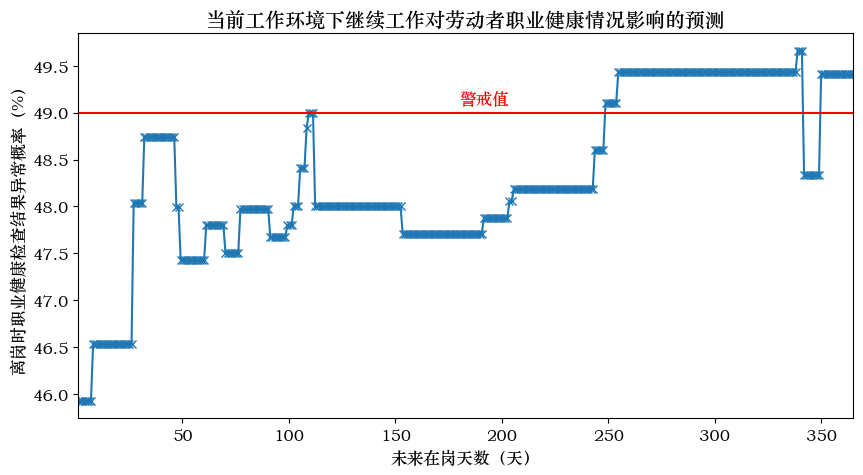

In [27]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(x, np.array(y)*100, "x-")
ax.set_xlabel("未来在岗天数（天）")
ax.set_ylabel("离岗时职业健康检查结果异常概率（%）")
ax.hlines(y=49, xmin=0, xmax=365, colors="red")
ax.annotate(xy=(182, 49),xytext=(180, 49.1), text="警戒值", color="red")
ax.set_xlim(1,365)
ax.set_title("当前工作环境下继续工作对劳动者职业健康情况影响的预测")
plt.show()

In [37]:
import plotly.graph_objects as go
diseases_name = ["是", "否"]
proba_results = [24, 76]
fig = go.Figure()
fig.add_trace(go.Bar(x=diseases_name, y=proba_results, name="职业禁忌证确诊概率"))
fig.update_layout(width=500,
                  height=500,
                  xaxis_title="上岗前职业健康检查-职业禁忌证-朴啉病",
                  yaxis_title="职业禁忌症确诊概率(%)",
                  font=dict(family="Courier New, monospace",
                                    size=15,
                                    color="RebeccaPurple"))

In [38]:
diseases_name = ["卟啉病", "中度贫血", "多发性周围神经病", "无相关职业禁忌证"]
proba_results = [24, 20, 15, 51]
fig = go.Figure()
fig.add_trace(go.Bar(x=diseases_name, y=proba_results, name="职业禁忌证确诊概率"))
fig.update_layout(width=500,
                  height=500,
                  xaxis_title="上岗前职业健康检查-职业禁忌证",
                  yaxis_title="职业禁忌症确诊概率(%)",
                  font=dict(family="Courier New, monospace",
                                    size=15,
                                    color="RebeccaPurple"))